# FL Experiment Analysis & Plotting Demo

This notebook demonstrates the Phase 5 analysis utilities:
- **E-1**: Plot utilities (convergence, RMSE/MAE, variance)
- **E-2**: Summary report generator

We'll run a quick federated experiment, then generate plots and a report.

In [3]:
# Setup: Add src to path (workspace-relative)
import sys
import importlib
from pathlib import Path

# Walk up from CWD to find project root (where src/ exists)
ROOT = Path.cwd()
while not (ROOT / "src").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent
SRC = ROOT / "src"
if not SRC.exists():
    raise FileNotFoundError(f"Could not find src/ by walking up from: {Path.cwd()}")
sys.path.insert(0, str(SRC))

# Force reload modules if already imported (useful during development)
for mod_name in list(sys.modules.keys()):
    if mod_name.startswith('analysis'):
        del sys.modules[mod_name]

# Check we can import analysis modules
from analysis import (
    plot_convergence,
    plot_rmse_mae,
    plot_client_variance,
    plot_algorithm_comparison,
    generate_all_plots,
    generate_experiment_report,
    generate_comparison_report,
    plot_participation_impact,
    plot_final_metrics_bar,
 )
print("✓ Analysis modules imported successfully")

✓ Analysis modules imported successfully


## 1. Run a Quick Federated Experiment

First, let's run a small FedAvg experiment to generate some data for plotting.

In [4]:
# Run a quick FedAvg experiment (or fall back to an existing experiment if torch can't load)
from pathlib import Path
import json
import os

# Torch can be installed but still fail to load on some Windows setups (DLL/runtime issues).
try:
    import torch  # noqa: F401
    HAS_TORCH = True
    TORCH_ERROR = None
except Exception as e:
    HAS_TORCH = False
    TORCH_ERROR = e

# Use ROOT from previous cell (project root)
EXPERIMENTS_DIR = ROOT / "experiments"

# Configuration (used only when running training)
SEED = 42
DATASET = "FD001"
MAX_CLIENTS = 5
ROUNDS = 20

if not HAS_TORCH:
    # Fallback: pick an experiment with actual data (rounds.csv should have >1 line)
    def has_data(exp_path):
        csv_path = exp_path / "logs" / "rounds.csv"
        if not csv_path.exists():
            return False
        # Check file has more than just header
        return os.path.getsize(csv_path) > 200  # Header is ~100 bytes, data adds more
    
    candidates = [
        p for p in EXPERIMENTS_DIR.iterdir()
        if p.is_dir() and has_data(p) and (p / "config.json").exists()
    ] if EXPERIMENTS_DIR.exists() else []
    candidates.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise RuntimeError(
            f"Torch failed to load, and no existing experiments with data were found under {EXPERIMENTS_DIR}. "
            "Run training from scripts once, or fix the torch DLL issue."
        )
    experiment_path = candidates[0]
    experiment_dir = str(experiment_path)
    experiment_id = experiment_path.name
    with open(experiment_path / "config.json", "r") as f:
        cfg = json.load(f)
    print("⚠ torch could not be loaded; skipping training in-notebook.")
    print(f"Torch error: {repr(TORCH_ERROR)}")
    print(f"Using existing experiment: {experiment_id}")
    print(f"  algorithm={cfg.get('algorithm')} dataset={cfg.get('dataset')} rounds={cfg.get('rounds')}")
else:
    # Training path (requires torch working)
    from server import FLServer, set_seed
    from client import create_clients_from_datasets
    from runner import FLRunner
    from data.preprocessing import preprocess_dataset
    from data.client_dataset import create_client_datasets, compute_all_clients_non_iid_stats
    from utils.logging import ExperimentLogger, generate_experiment_id
    from utils.paths import get_experiment_dir

    set_seed(SEED)

    # Preprocess
    print("Loading data...")
    result = preprocess_dataset(DATASET)
    client_datasets = create_client_datasets(result["splits"])
    n_features = result["metadata"]["n_features"]

    # Limit clients
    client_ids = list(client_datasets.keys())[:MAX_CLIENTS]
    client_datasets = {k: client_datasets[k] for k in client_ids}
    print(f"Using {len(client_datasets)} clients with {n_features} features")

Loading data...
Using 5 clients with 17 features


In [7]:
# Create FL components (skipped if torch can't load)
if not HAS_TORCH:
    print("Skipped: training setup (torch unavailable)")
else:
    experiment_id = f"demo_fedavg_{generate_experiment_id()}"
    print(f"Experiment ID: {experiment_id}")

    # Logger
    config_data = {
        "algorithm": "fedavg",
        "dataset": DATASET,
        "rounds": ROUNDS,
        "local_epochs": 1,
        "batch_size": 64,
        "lr": 0.001,
        "participation": 1.0,
        "n_clients": len(client_datasets),
        "n_features": n_features,
        "seed": SEED,
    }

    logger = ExperimentLogger(
        experiment_id=experiment_id,
        seed=SEED,
        config=config_data,
        prevent_overwrite=False,
    )

    # Log non-IID stats
    non_iid_stats = compute_all_clients_non_iid_stats(client_datasets, result["raw_df"])
    for stats in non_iid_stats:
        logger.log_non_iid(**stats)

    # Server and clients
    server = FLServer(input_channels=n_features, device="cpu", seed=SEED)
    server.init_model()

    clients = create_clients_from_datasets(
        client_datasets, device="cpu", learning_rate=0.001, batch_size=64, local_epochs=1
    )

    # Runner
    runner = FLRunner(server=server, clients=clients, logger=logger, device="cpu")

    n_params = sum(p.numel() for p in server.global_model.parameters())
    print(f"Server model: {n_params:,} parameters")
    print(f"Clients: {list(clients.keys())}")

Experiment ID: demo_fedavg_20260117_231423_5a820de0
Initialized global TCN model with 71,233 parameters
Server model: 71,233 parameters
Clients: [1, 2, 3, 4, 5]


In [8]:
# Run training (skipped if torch can't load)
if not HAS_TORCH:
    print("Skipped: training run (torch unavailable)")
else:
    print(f"\nTraining for {ROUNDS} rounds...")
    metrics = runner.run_training(
        max_rounds=ROUNDS,
        participation_fraction=1.0,
        algorithm="fedavg",
        verbose=True,
    )

    # Final evaluation
    test_metrics = runner.evaluate_global_model()
    print(f"\n✓ Final Test RMSE: {test_metrics['test_rmse']:.2f}")
    print(f"✓ Final Test MAE: {test_metrics['test_mae']:.2f}")


Training for 20 rounds...
Starting FL training: 20 rounds, 100% participation, fedavg
Round 10/20: RMSE=44.08, MAE=41.83, Time=0.91s
Round 20/20: RMSE=39.02, MAE=36.74, Time=0.64s
Training complete. Total time: 15.2s

✓ Final Test RMSE: 11.36
✓ Final Test MAE: 9.54


In [9]:
# Save summary (only when we actually ran training)
if not HAS_TORCH:
    print("Skipped: summary write (using existing experiment)")
else:
    import json
    from pathlib import Path

    experiment_dir = get_experiment_dir(experiment_id)
    logs_dir = Path(experiment_dir) / "logs"

    summary = {
        "experiment_id": experiment_id,
        "algorithm": "fedavg",
        "dataset": DATASET,
        "test_rmse": test_metrics["test_rmse"],
        "test_mae": test_metrics["test_mae"],
    }

    with open(logs_dir / "summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    print(f"Experiment saved to: {experiment_dir}")

Experiment saved to: c:\Users\HP\Desktop\FL_CMAPPS\experiments\demo_fedavg_20260117_231423_5a820de0


## 2. Generate Plots (E-1)

Now let's use the plotting utilities to visualize the experiment results.

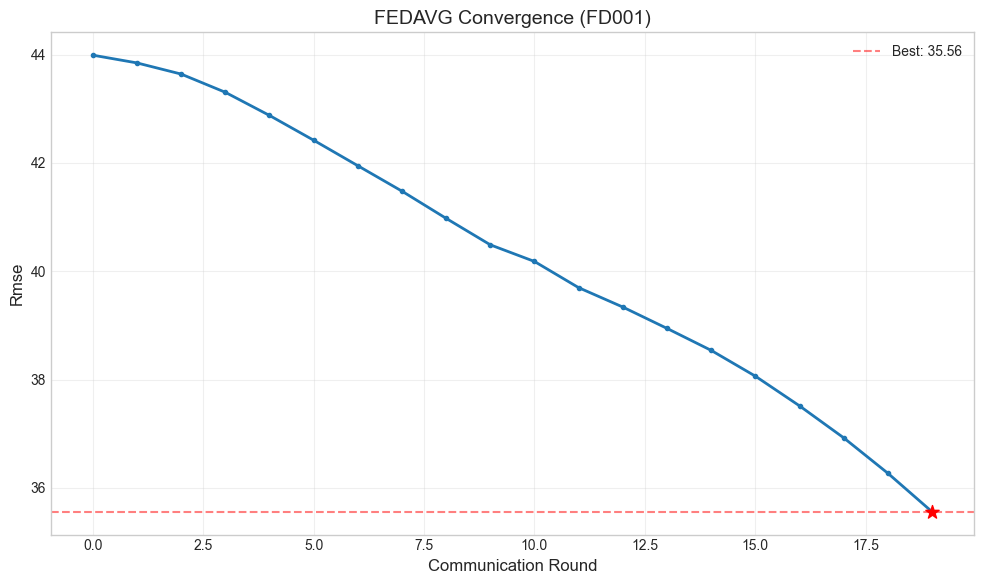

In [10]:
import matplotlib.pyplot as plt

# Generate convergence plot
fig = plot_convergence(experiment_dir, metric='global_rmse', save=True, show=True)
plt.show()

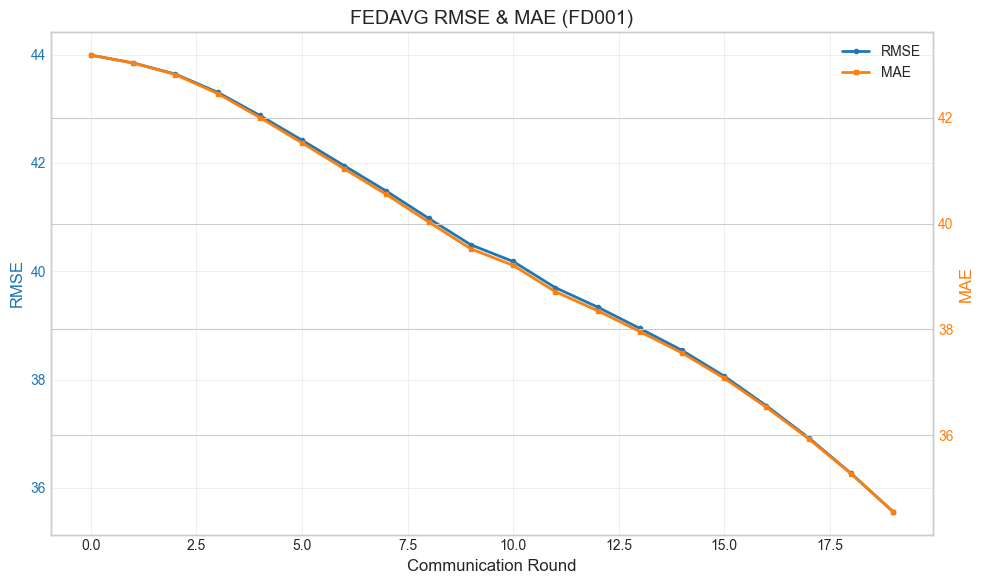

In [11]:
# Generate RMSE/MAE dual-axis plot
fig = plot_rmse_mae(experiment_dir, save=True, show=True)
plt.show()

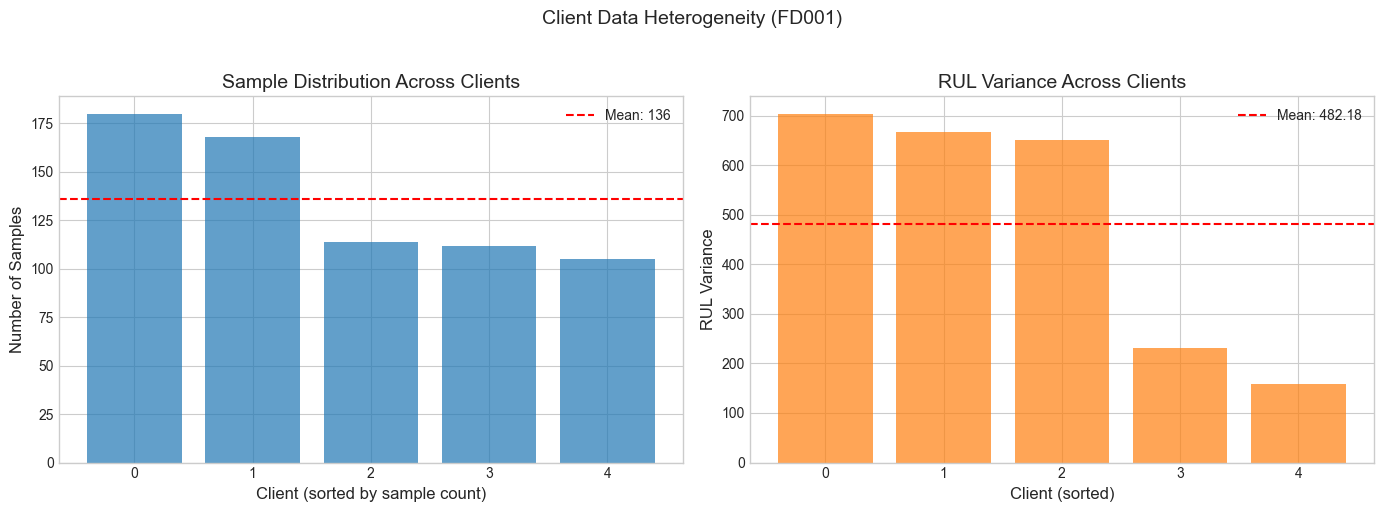

In [12]:
# Generate client variance plot (non-IID visualization)
fig = plot_client_variance(experiment_dir, save=True, show=True)
plt.show()

In [13]:
# Or generate all plots at once
from analysis import generate_all_plots

figures = generate_all_plots(experiment_dir, show=False)
print(f"\nGenerated {len(figures)} plots")

Generating plots for: c:\Users\HP\Desktop\FL_CMAPPS\experiments\demo_fedavg_20260117_231423_5a820de0
  ✓ Convergence plot (RMSE)
  ✓ RMSE/MAE plot
  ✓ Client variance plot

Plots saved to: c:\Users\HP\Desktop\FL_CMAPPS\experiments\demo_fedavg_20260117_231423_5a820de0\plots

Generated 3 plots


In [14]:
# List generated plot files
plots_dir = Path(experiment_dir) / 'plots'
print("Generated plots:")
for f in sorted(plots_dir.glob('*')):
    print(f"  - {f.name}")

Generated plots:
  - client_variance.png
  - client_variance.svg
  - convergence_rmse.png
  - convergence_rmse.svg
  - rmse_mae.png
  - rmse_mae.svg


## 3. Generate Report (E-2)

Generate a markdown summary report with links to logs and plots.

In [15]:
# Generate experiment report
report_path = generate_experiment_report(experiment_dir)

# Display the report
print("\n" + "="*60)
print("GENERATED REPORT PREVIEW")
print("="*60 + "\n")

with open(report_path) as f:
    content = f.read()
    # Show first 80 lines
    lines = content.split('\n')[:80]
    print('\n'.join(lines))
    if len(content.split('\n')) > 80:
        print("\n... [truncated] ...")

Report generated: c:\Users\HP\Desktop\FL_CMAPPS\experiments\demo_fedavg_20260117_231423_5a820de0\report\index.md

GENERATED REPORT PREVIEW

# FEDAVG Experiment Report — FD001

**Experiment ID:** `demo_fedavg_20260117_231423_5a820de0`  
**Generated:** 2026-01-17 23:16:00  
**Author:** FL Experiment Runner

---

## 1. Configuration Summary

| Parameter | Value |
|-----------|-------|
| Algorithm | fedavg |
| Dataset | FD001 |
| Rounds | 20 |
| Local Epochs | 1 |
| Batch Size | 64 |
| Learning Rate | 0.001 |
| Participation | 100% |
| Num Clients | 5 |
| Seed | 42 |

---

## 2. Final Results

| Metric | Value |
|--------|-------|
| **Test RMSE** | **11.36** |
| **Test MAE** | **9.54** |
| Total Time | 0.0s |
| Avg Round Time | 0.00s |

---

## 3. Convergence Analysis

Training completed **20** rounds.

- **Initial RMSE:** 43.99
- **Final RMSE:** 35.56
- **Best RMSE:** 35.56 (Round 20)
- **Improvement:** 8.43 (19.2%)

### Plots

![client_variance](../plots/client_variance.png)

![convergen

## 4. List All Generated Artifacts

In [16]:
# Show experiment directory structure
from pathlib import Path

def show_tree(path, prefix=""):
    path = Path(path)
    contents = sorted(path.iterdir())
    for i, item in enumerate(contents):
        is_last = i == len(contents) - 1
        connector = "└── " if is_last else "├── "
        print(f"{prefix}{connector}{item.name}")
        if item.is_dir():
            extension = "    " if is_last else "│   "
            show_tree(item, prefix + extension)

print(f"Experiment Directory: {experiment_dir}\n")
show_tree(experiment_dir)

Experiment Directory: c:\Users\HP\Desktop\FL_CMAPPS\experiments\demo_fedavg_20260117_231423_5a820de0

├── config.json
├── logs
│   ├── non_iid.csv
│   ├── rounds.csv
│   └── summary.json
├── plots
│   ├── client_variance.png
│   ├── client_variance.svg
│   ├── convergence_rmse.png
│   ├── convergence_rmse.svg
│   ├── rmse_mae.png
│   └── rmse_mae.svg
└── report
    └── index.md


## 5. Multi-Experiment Comparison (Optional)

If you have multiple experiments, you can compare them.

In [17]:
# Example: Compare multiple algorithms (if you have run them)
# Uncomment and modify paths as needed

# from analysis import plot_algorithm_comparison, generate_comparison_report
# 
# experiments = {
#     'FedAvg': 'experiments/fedavg_FD001_xxx',
#     'FedProx': 'experiments/fedprox_FD001_xxx',
#     'SCAFFOLD': 'experiments/scaffold_FD001_xxx'
# }
# 
# # Plot comparison
# plot_algorithm_comparison(
#     experiments, 
#     metric='global_rmse',
#     save_dir='experiments/comparison',
#     show=True
# )
# 
# # Generate comparison report
# generate_comparison_report(
#     experiments,
#     output_dir='experiments/comparison'
# )

print("Multi-experiment comparison functions available:")
print("  - plot_algorithm_comparison()")
print("  - plot_participation_impact()")
print("  - plot_final_metrics_bar()")
print("  - generate_comparison_report()")

Multi-experiment comparison functions available:
  - plot_algorithm_comparison()
  - plot_participation_impact()
  - plot_final_metrics_bar()
  - generate_comparison_report()


## Summary

Phase 5 utilities successfully demonstrated:

### E-1: Plot Utilities
- `plot_convergence()` — Training convergence (RMSE/loss over rounds)
- `plot_rmse_mae()` — Dual-axis RMSE and MAE plot
- `plot_client_variance()` — Non-IID data distribution visualization
- `plot_algorithm_comparison()` — Compare multiple algorithms
- `plot_participation_impact()` — Impact of participation rates
- `generate_all_plots()` — Generate all applicable plots at once

### E-2: Report Generator
- `generate_experiment_report()` — Single experiment markdown report
- `generate_comparison_report()` — Multi-experiment comparison report

All outputs saved under `experiments/{id}/plots/` and `experiments/{id}/report/`.